# Dependencies

In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
import gurobipy as gp

In [5]:
data_path = Path("../data_will/48_Industry_Portfolios.CSV")
df = pd.read_csv(data_path, index_col=0)
df.index = pd.to_datetime(df.index, format="%Y%m")  # clean the index to be datetime

# constants
start_date = "2019-12-01"
N = 48
df = df.loc[df.index >= start_date, :]  # select last 5 years

df = df.astype(dtype= 'float32')

# df = df / 100

df.describe()


,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,...,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,1.711667,0.498000,0.826500,0.516833,1.285667,-0.256500,1.378000,1.248667,0.688833,0.473333,...,0.864833,1.164500,1.599667,1.497500,1.115333,1.170167,1.306167,1.408333,1.837167,1.397500
std,6.808964,4.191802,5.076224,4.506729,5.675682,9.453468,8.880008,7.771293,4.803802,8.238357,...,5.948642,7.123999,6.113119,6.129512,6.405528,7.475410,5.145520,9.773773,7.073771,5.605093
min,-12.510000,-9.300000,-15.440000,-9.920000,-11.620000,-18.850000,-27.969999,-22.650000,-10.590000,-19.459999,...,-13.800000,-16.809999,-17.820000,-11.240000,-22.120001,-23.900000,-12.740000,-35.950001,-16.860001,-14.990000
25%,-3.070000,-2.392500,-1.555000,-2.872500,-2.317500,-6.070000,-3.892500,-4.265000,-1.852500,-5.930000,...,-3.610000,-4.275000,-1.655000,-3.090000,-2.330000,-3.362500,-2.945000,-3.252500,-3.507500,-2.347500
50%,2.445000,0.290000,1.070000,0.300000,1.445000,-0.955000,1.425000,1.290000,0.405000,0.520000,...,0.870000,0.590000,1.085000,1.590000,0.610000,1.815000,1.560000,0.850000,2.115000,1.445000
75%,5.847500,3.450000,4.380000,3.255000,5.267500,5.705000,7.442500,5.265000,3.835000,5.875000,...,5.640000,7.545000,5.327500,5.212500,5.355000,5.512500,3.782500,6.682500,6.580000,5.517500
max,16.160000,11.260000,12.680000,11.090000,12.420000,21.059999,19.330000,23.799999,11.400000,17.510000,...,11.790000,17.440001,16.110001,18.790001,18.670000,18.309999,12.820000,21.420000,16.879999,16.610001


In [6]:
# QUESTION 1
cov = df.cov()
mean = df.mean(axis=0)
std = np.sqrt(np.diag(cov))
ret = 1
K = 5
l = 9 #max position size (500%)

# Create an empty optimization model
m = gp.Model()
m.setParam('OutputFlag', 0)

# Add variables: x[i] denotes the proportion of capital invested in stock i
# 0 <= x[i] <= 1
x = m.addMVar(len(mean), lb=-np.inf, ub=np.inf, name="x")
x_plus = m.addMVar(len(mean), lb= 0, ub=np.inf, name="x_plus")
x_minus = m.addMVar(len(mean), lb= 0, ub=np.inf, name="x_minus")
b = m.addMVar(len(mean), vtype=gp.GRB.BINARY, name="b")

# Budget constraint: all investments sum up to 1
m.addConstr(x.sum() == 1, name="Budget_Constraint")
m.addConstr(x == x_plus - x_minus, name= "Position_Balance")
m.addConstr(x_plus <= l*b, name= "Long_Indicator")
m.addConstr(x_minus <= l*b, name= "Short_Indicator")
m.addConstr(b.sum() <= K, name="Cardinality")
m.addConstr(mean.to_numpy() @ x >= ret , name="Target_Return")

# Define objective function: Minimize overall risk
m.setObjective(x.T @ cov.to_numpy() @ x, gp.GRB.MINIMIZE)

Restricted license - for non-production use only - expires 2026-11-23


In [7]:
m.optimize()

In [8]:
print(f"Minimum risk:     {m.ObjVal:.6f}")
print(f"Expected return:  {mean @ x.X:.6f}")
print(f"Solution time:    {m.Runtime:.2f} seconds\n")

# Print investments (with non-negligible value, i.e., > 1e-5)
positions = pd.Series(name="Position", data= x.X, index= mean.index)
print(f"Number of assets: {positions[abs(positions) > 1e-5].count()}\n")
print(positions[abs(positions) > 1e-5])
index = positions[abs(positions) > 1e-5].index
result = pd.DataFrame({'mean' : df[index].mean(),
                       'var' : df[index].var()})
print(result)

Minimum risk:     11.368631
Expected return:  1.000000
Solution time:    2.71 seconds

Number of assets: 5

Agric    0.224955
Food     0.631956
Drugs    0.377866
Chems   -0.441284
BusSv    0.206507
Name: Position, dtype: float64
           mean        var
Agric  1.711667  46.361992
Food   0.498000  17.571199
Drugs  0.908667  18.986731
Chems  0.822667  48.662903
BusSv  1.549167  38.129124


# Unconstrained Tangency Portfolio

### Maximum Sharpe Ratio Portfolio (i.e., Tangency Portfolio)

A particular portfolio on the efficient side of the mean-variance frontier constructed using risky assets is the tangency portfolio. This portfolio lies on the mean-variance frontier of risky assets and achieves the maximum possible Sharpe ratio.

#### Optimization Problem:

Maximize (over **x**):
$$
\frac{\mathbf{x}'(\mathbb{E}[R] - r_f)}{\sqrt{\mathbf{x}'\Sigma \mathbf{x}}}
$$

Subject to:
$$
\sum x_i = 1
$$


In [4]:
# QUESTION 1
cov = df.cov()
mean = df.mean(axis=0)
std = np.sqrt(np.diag(cov))
ret = 0.03
K = 5
l = 5 #max position size (500%)


# Create an empty optimization model
m = gp.Model()
m.Params.Threads=8

# Add variables: x[i] denotes the proportion of capital invested in stock i
# 0 <= x[i] <= 1
x = m.addMVar(len(mean), lb=-np.inf, ub=np.inf, name="x")
x_plus = m.addMVar(len(mean), lb= 0, ub=np.inf, name="x_plus")
x_minus = m.addMVar(len(mean), lb= 0, ub=np.inf, name="x_minus")
b = m.addMVar(len(mean), vtype=gp.GRB.BINARY, name="b")

# Budget constraint: all investments sum up to 1
m.addConstr(x.sum() == 1, name="Budget_Constraint")
m.addConstr(x == x_plus - x_minus, name= "Position_Balance")
m.addConstr(x_plus <= l*b, name= "Long_Indicator")
m.addConstr(x_minus <= l*b, name= "Short_Indicator")
m.addConstr(b.sum() <= K, name="Cardinality")
m.addConstr(x.T @ mean.to_numpy() >= ret , name="Target_Return")

# Maxmize the rReturns
m.setObjective(x.T @ cov.to_numpy() @ x, gp.GRB.MINIMIZE)

Restricted license - for non-production use only - expires 2026-11-23
Set parameter Threads to value 8


In [5]:
m.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 7 3800X 8-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 8 threads

Non-default parameters:
Threads  8

Optimize a model with 147 rows, 192 columns and 480 nonzeros
Model fingerprint: 0x544ccc77
Model has 1176 quadratic objective terms
Variable types: 144 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [3e-03, 5e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e-03, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-02, 5e+00]
Found heuristic solution: objective 0.0150301
Presolve time: 0.02s
Presolved: 147 rows, 192 columns, 479 nonzeros
Presolved model has 1176 quadratic objective terms
Variable types: 144 continuous, 48 integer (48 binary)

Root relaxation: objective 3.266972e-04, 361 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node   

In [6]:
try:
    var = x.X @ cov.to_numpy() @ x.X
    rets = mean @ x.X
    SR = rets/np.sqrt(var)


    positions = pd.Series(name="Position", data= x.X, index= mean.index)
    index = positions[abs(positions) > 1e-5].index
    result = pd.DataFrame({'mean' : df[index].mean(),
                        'var' : df[index].var()})
except:
    rets = 0

print(f"Sharpe Ratio:     {rets / np.sqrt(var)}")
print(f"Expected return:  {rets:.6f}")
print(f"Variance :  {var:.6f}")
print(f"Solution time:    {m.Runtime:.2f} seconds\n")

# Print investments (with non-negligible value, i.e., > 1e-5)
positions = pd.Series(name="Position", data= x.X, index= mean.index)
print(f"Number of assets: {positions[abs(positions) > 1e-5].count()}\n")
print(positions[abs(positions) > 1e-5])
index = positions[abs(positions) > 1e-5].index
result = pd.DataFrame({'mean' : df[index].mean(),
                       'var' : df[index].var()})
print(result)

Sharpe Ratio:     0.5750810948247996
Expected return:  0.030000
Variance :  0.002721
Solution time:    4.80 seconds

Number of assets: 5

Hlth    -0.994917
Drugs    1.319945
BldMt    0.852698
Util     0.918215
Paper   -1.095942
Name: Position, dtype: float64
           mean       var
Hlth   0.004975  0.005164
Drugs  0.009087  0.001899
BldMt  0.020390  0.006759
Util   0.009712  0.002639
Paper  0.003055  0.003033


# Without Short Selling

In [1]:
# QUESTION 1
cov = df.cov()
mean = df.mean(axis=0)
std = np.sqrt(np.diag(cov))
ret = 1
K = 5
l = 5 #max position size (500%)
ret = 0.03 #example of a variance

# Create an empty optimization model
m = gp.Model()
m.Params.Threads=8

# Add variables: x[i] denotes the proportion of capital invested in stock i
# 0 <= x[i] <= 1
x = m.addMVar(len(mean), lb=0, ub=np.inf, name="x")
b = m.addMVar(len(mean), vtype=gp.GRB.BINARY, name="b")

# Budget constraint: all investments sum up to 1
m.addConstr(x.sum() == 1, name="Budget_Constraint")
m.addConstr(x <= l*b, name= "Long_Indicator")
m.addConstr(b.sum() <= K, name="Cardinality")
m.addConstr(x.T @ mean.to_numpy() >= ret , name="Target_Return")

# Maxmize the rReturns
m.setObjective(x.T @ cov.to_numpy() @ x, gp.GRB.MINIMIZE)

NameError: name 'df' is not defined

In [36]:
m.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 7 3800X 8-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 8 threads

Non-default parameters:
Threads  8

Optimize a model with 51 rows, 96 columns and 240 nonzeros
Model fingerprint: 0xc64f965a
Model has 1176 quadratic objective terms
Variable types: 48 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [3e-03, 5e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e-03, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-02, 5e+00]
Presolve time: 0.00s
Presolved: 51 rows, 96 columns, 239 nonzeros
Presolved model has 1176 quadratic objective terms
Variable types: 48 continuous, 48 integer (48 binary)

Root relaxation: objective 5.664767e-03, 24 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl 

In [37]:
try:
    var = x.X @ cov.to_numpy() @ x.X
    rets = mean @ x.X
    SR = rets/np.sqrt(var)


    positions = pd.Series(name="Position", data= x.X, index= mean.index)
    index = positions[abs(positions) > 1e-5].index
    result = pd.DataFrame({'mean' : df[index].mean(),
                        'var' : df[index].var()})
except:
    rets = 0

print(f"Sharpe Ratio:     {rets / np.sqrt(var)}")
print(f"Expected return:  {rets:.6f}")
print(f"Variance :  {var:.6f}")
print(f"Solution time:    {m.Runtime:.2f} seconds\n")

# Print investments (with non-negligible value, i.e., > 1e-5)
positions = pd.Series(name="Position", data= x.X, index= mean.index)
print(f"Number of assets: {positions[abs(positions) > 1e-5].count()}\n")
print(positions[abs(positions) > 1e-5])
index = positions[abs(positions) > 1e-5].index
result = pd.DataFrame({'mean' : df[index].mean(),
                       'var' : df[index].var()})
print(result)

Sharpe Ratio:     0.3985935312039446
Expected return:  0.030000
Variance :  0.005665
Solution time:    0.01 seconds

Number of assets: 3

Autos    0.033243
Coal     0.310189
Chips    0.656568
Name: Position, dtype: float64
           mean       var
Autos  0.037858  0.025154
Coal   0.035698  0.019848
Chips  0.026910  0.005822


In [ ]:
def max_sharpe_ratio(df: pd.DataFrame, exp_return: float, short_constraint: bool) -> tuple:
    """ 
    Computes the maximum sharpe ratio for a given return

    Inputs
        df: dataframe of monthly returns, each colum is a different asset
        exp_return: expected return for the sharpe ratio
        short_constraint: if the short constraint is active
    
    Outputs
        x: weights of the assets
        SR: max Sharpe Ratio for the return
        result: dataframe of positions 
    """
    cov = df.cov()
    mean = df.mean(axis=0)

    K = 5
    l = 5 #max position size (500%)

    # Create an empty optimization model
    m = gp.Model()
    m.setParam('OutputFlag', 0)
    m.Params.Threads=8

    # Add variables: x[i] denotes the proportion of capital invested in stock i
    
    b = m.addMVar(len(mean), vtype=gp.GRB.BINARY, name="b")

    if short_constraint:
        x = m.addMVar(len(mean), lb=-np.inf, ub=np.inf, name="x")
        x_plus = m.addMVar(len(mean), lb= 0, ub=np.inf, name="x_plus")
        x_minus = m.addMVar(len(mean), lb= 0, ub=np.inf, name="x_minus")

        # Budget constraint: all investments sum up to 1
        m.addConstr(x == x_plus - x_minus, name= "Position_Balance")
        m.addConstr(x_plus <= l*b, name= "Long_Indicator")
        m.addConstr(x_minus <= l*b, name= "Short_Indicator")
    else:
        x = m.addMVar(len(mean), lb=0, ub=np.inf, name="x")
        m.addConstr(x <= l*b, name= "Long_Indicator")

    # Budget constraint: all investments sum up to 1
    
    m.addConstr(x.sum() == 1, name="Budget_Constraint")
    m.addConstr(b.sum() <= K, name="Cardinality")
    m.addConstr(x.T @ mean.to_numpy() >= exp_return , name="Target_Return")

    # Minimize variance
    m.setObjective(x.T @ cov.to_numpy() @ x, gp.GRB.MINIMIZE)

    m.optimize()

    try:
        var = x.X @ cov.to_numpy() @ x.X
        rets = mean @ x.X
        SR = rets/np.sqrt(var)

        positions = pd.Series(name="Position", data= x.X, index= mean.index)
        index = positions[abs(positions) > 1e-5].index
        result = pd.DataFrame({'mean' : df[index].mean(),
                                'var' : df[index].var()})
    except:
        return None, None, None

    return SR, x.X, result

SR, _, _ = max_sharpe_ratio(df, 0.03, short_constraint= True)
SR

np.float64(0.11063678079648749)

In [26]:
rets = np.linspace(0, 40, 250)
sharpe = np.zeros(len(rets))
for i in range(len(rets)):
    SR, _, _ = max_sharpe_ratio(df= df, exp_return= rets[i], short_constraint= False)
    sharpe[i] = SR

sharpe

array([0.20525083, 0.20525083, 0.20525083, 0.20525083, 0.20525083,
       0.21697721, 0.25575646, 0.29094218, 0.31985756, 0.34547626,
       0.36746849, 0.38438611, 0.39697144, 0.40603086, 0.41426209,
       0.41769126, 0.41706973, 0.412907  , 0.40602281, 0.39314712,
       0.37252703, 0.34990279, 0.32815397, 0.30499232,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

In [24]:
idmax = np.nanargmax(sharpe)

SR, _, position = max_sharpe_ratio(df= df, exp_return= rets[idmax], short_constraint= True)
position

,mean,var
Hlth,0.497500,51.636860
Drugs,0.908667,18.986731
BldMt,2.039000,67.591072
Util,0.971167,26.386791
Paper,0.305500,30.328560


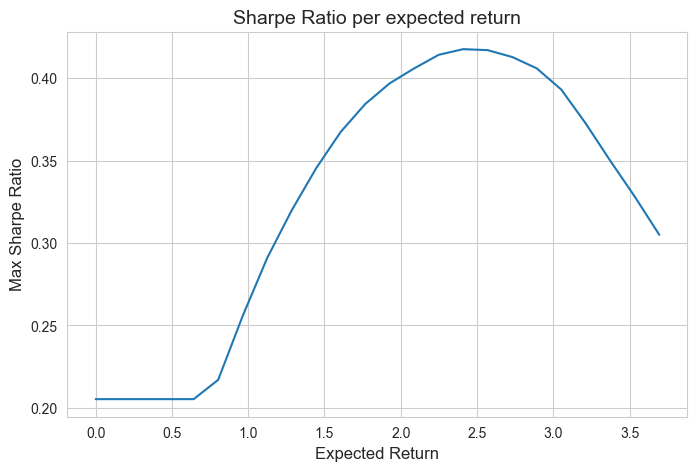

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(8, 5))
sns.lineplot(y=sharpe, x= rets)
# Add Title and Labels
plt.title("Sharpe Ratio per expected return", fontsize=14)
plt.xlabel("Expected Return", fontsize=12)
plt.ylabel("Max Sharpe Ratio", fontsize=12)

# Show the Plot
plt.show()